## Validation analysis against open/closed cells
---------------
This notebook focuses on the validation analysis, which includes inference of trained model with lablled input data and clustering against the output of model.

--------------
### Load module

In [369]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from math import ceil,sqrt
%matplotlib inline

# pyspark libs
#import pyspark
#from pyspark import SparkContext 
#from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel
#import matplotlib.pyplot as plt
#from matplotlib import patches as mpl_patches

In [370]:
## directory where your put lib_hdfs
libdir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [371]:
sys.path.insert(1,os.path.join(sys.path[0],libdir)) # this line helps you to use your own functions in another directory
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

### Load Model

In [372]:
homedir = libdir
datadir = homedir+"/model/m2_02_global_2000_2018_band28_29_31"
step = 100000 # DONOT change so far

In [373]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Load labelled open/closed cell

Load the date files of your labeled patches here. You can get these files from running and labeling patches in cloud_labeling.ipynb

In [374]:
#enter the name of the directory containing your dates files, mod02, and mod35 data for your labeled patches
filesdir = "/home/rubywerman/clouds/src_analysis/labeled_data/"

If your date file is in the form of a txt file: uncomment the following cell to read in your dates:

In [375]:
#closed_file_name = filesdir + 'close_cells_mod02/close_dates_1.txt"
#closed_text_file = open(closed_file_name, "r")
#closed_dates = closed_text_file.read().split('\n')

#open_file_name = filesdir + "open_cells_mod02/open_dates_1.txt"
#open_text_file = open(open_file_name, "r")
#open_dates = open_text_file.read().split('\n')

In [376]:
#select directory path for given date
def get_data(d):
    return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))

The following are patch and cluster objects that make it easy to access and write new data 

In [377]:
class Patch:        
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None, has_coord=False, coords=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature
        self.has_coord = has_coord
        self.coords = coords
        
    def print_attr(self):
        print("date: " + self.date)
        print("isOpen: " + str(self.isOpen))
        print("label: " + str(self.label))
        if len(self.coords) > 0:
            print("coords: ")
            for i in self.coords:
                print(str(i))
        
        
class Cluster:
    def __init__(self, label, patches=None, means=None, std=None, num_open=0):
        self.label = label
        self.patches = patches
        self.means = means
        self.std = std
        self.num_open = num_open

        
#generates list of 6 means for each band in the patch list 
def get_band_means(patch_list):
    mean_list = []
    for i in range(6):
        mean_list.append(np.nanmean([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return mean_list

#generates list of 6 stds for each band in the patch list 
def get_band_std(patch_list):
    std_list = []
    for i in range(6):
        std_list.append(np.nanstd([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return std_list

If your patch data is in the form of a list of patch instances, run the cell below to access patch data

In [577]:
class_patch_list = np.load(filesdir + 'class_patch_data/071619.npy')

In [578]:
patch_list = np.load(filesdir + 'class_patch_data/072219.npy')

In [579]:
all_patches = []
for p in class_patch_list:
    all_patches.append(p)
for p in patch_list:
    all_patches.append(p)

If your patch is in the form of MOD02, MOD35, and a coordinate file for each date that contain patches, run the following three cells below to access patch data 

In [396]:
# enter name of text file containing the dates
file_name = "/home/rubywerman/clouds/src_analysis/dates/label1.txt"
text_file = open(file_name, "r")
dates = text_file.read().split('\n')

In [342]:
#collect close patch 35 and 02 data
closed_patch_class_list = []
for d in dates:
    if os.path.exists(filesdir + 'close_cells1/closed_'+ d +'.npy'):
        file_name_a = filesdir + 'close_cells1/closed_'+ d +'.npy'
        #closed_date_data = np.load(file_name_a[:72] + file_name_a[-4:])
        closed_date_data = np.load(file_name_a)
        file_name_b = filesdir + 'close_cell_coords1/closed_coords'+ d +'.npy'
        if os.path.exists(file_name_b):
            coords = np.load(file_name_b)
        #else:
            #coords = 6
        if os.path.exists(filesdir + 'c35/close_35_'+ d +'.npy'): 
            thirtyFive = np.load(filesdir + 'c35/close_35_'+ d +'.npy')
        ##else:
            #thirtyFive = 6
        for patch in range(len(closed_date_data)):
            #if type(thirtyFive) is not int or type(coords) is not int:
            closed_patch_class_list.append(Patch(date=d, isOpen=False, thirtyFive=thirtyFive, zeroTwo=closed_date_data[patch], label=None, feature=None, has_coord=True, coords=coords[patch]))
            #else:
               # closed_patch_class_list.append(Patch(date=d, isOpen=False, thirtyFive=None, zeroTwo=closed_date_data[patch], label=None, feature=None, has_coord=False, coords=None))


In [343]:
len(closed_patch_class_list)

11

In [344]:
#collect open patch 35 and 02 data
open_patch_class_list = []
for d in dates:
    if os.path.exists(filesdir + 'open_cells1/open_'+ d +'.npy'):
        file_name_a = filesdir + 'open_cells1/open_'+ d +'.npy'
        #open_date_data = np.load(file_name_a[:69] + file_name_a[-4:])
        open_date_data = np.load(file_name_a)
        file_name_b = filesdir + 'open_cell_coords1/open_coords'+ d +'.npy'
        if os.path.exists(file_name_b):
            coords = np.load(file_name_b)
        #else: 
           # coords = 2
        if os.path.exists(filesdir + 'o35/open_35_'+ d +'.npy'):
            thirtyFive = np.load(filesdir + 'o35/open_35_'+ d +'.npy')
      #  else: 
      #      thirtyFive = 2
        for patch in range(len(open_date_data)):
            #if type(thirtyFive) is not int and type(coords) is not int:
            open_patch_class_list.append(Patch(date=d, isOpen=True, thirtyFive=thirtyFive, zeroTwo=open_date_data[patch], label=None, feature=None, has_coord=True, coords=coords[patch]))
            #else:
           #     open_patch_class_list.append(Patch(date=d, isOpen=True, thirtyFive=None, zeroTwo=open_date_data[patch], label=None, feature=None, has_coord=False, coords=None))


In [580]:
# here make patches list
#class_patch_list = open_patch_class_list + closed_patch_class_list
class_patch_list = [patch for patch in all_patches if type(patch.zeroTwo) is not list]

In [581]:
print("Number of patches recorded: " + str(len(class_patch_list)))

Number of patches recorded: 52


### Run Analysis

we will use a type of hierarchical clusering called `Agglometative clustering` 

How to donwload agglomerative [sklearn aggl](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  

`from sklearn.cluster import AgglomerativeClustering`

###### Inference

In [582]:
encs_list = []
for patch in class_patch_list:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list += [encs.mean(axis=(1,2))]

In [583]:
features = np.concatenate(encs_list, axis=0)

In [584]:
print(features.shape)  # make sure, the shape is [#number of patches, 128]

(52, 128)


##### Clustering

In [585]:
from sklearn.cluster import AgglomerativeClustering

In [597]:
# N in [2, inf), you can change this number but save the result differently
num_clusters = 6

In [598]:
clustering = AgglomerativeClustering(num_clusters)

In [599]:
#turns any NAN values to 0 so code doesn't crash
cleaned_features = np.nan_to_num(features)

In [600]:
#generate clustering data
label = clustering.fit_predict(cleaned_features)

In [601]:
label

array([0, 0, 5, 5, 5, 5, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3,
       3, 3, 5, 5, 5, 5, 2, 2, 0, 3, 3, 3, 2, 2, 4, 1, 1, 1, 2, 2, 1, 5,
       5, 5, 5, 0, 0, 5, 5, 1])

In [602]:
len(class_patch_list), len(label)

(52, 52)

In [603]:
#assign each patch instance its correct label
for i in range(len(class_patch_list)):
    class_patch_list[i].label = label[i]

In [604]:
#make a list of clusters
list_clusters = [Cluster(label=i) for i in range(num_clusters)]

In [605]:
#add patches to cluster objects
for p in class_patch_list:
    matching_cluster = list_clusters[p.label]
    if p.isOpen:
        matching_cluster.num_open += 1
    if not matching_cluster.patches:
        matching_cluster.patches = [p]
    else:
        matching_cluster.patches.append(p)

## Visualize clustering accuracy

Visualize how open and closed clusteres are differently classified. Run this section to create a stacked bar graph of the clusters and a t-Distributed Stochastic Neighbor Embedding (t-SNE) plot.

In [606]:
open_clusters = [c.num_open for c in list_clusters]
closed_clusters = [len(c.patches) - c.num_open for c in list_clusters]

W0722 16:45:49.277245 139663473805120 legend.py:1282] No handles with labels found to put in legend.


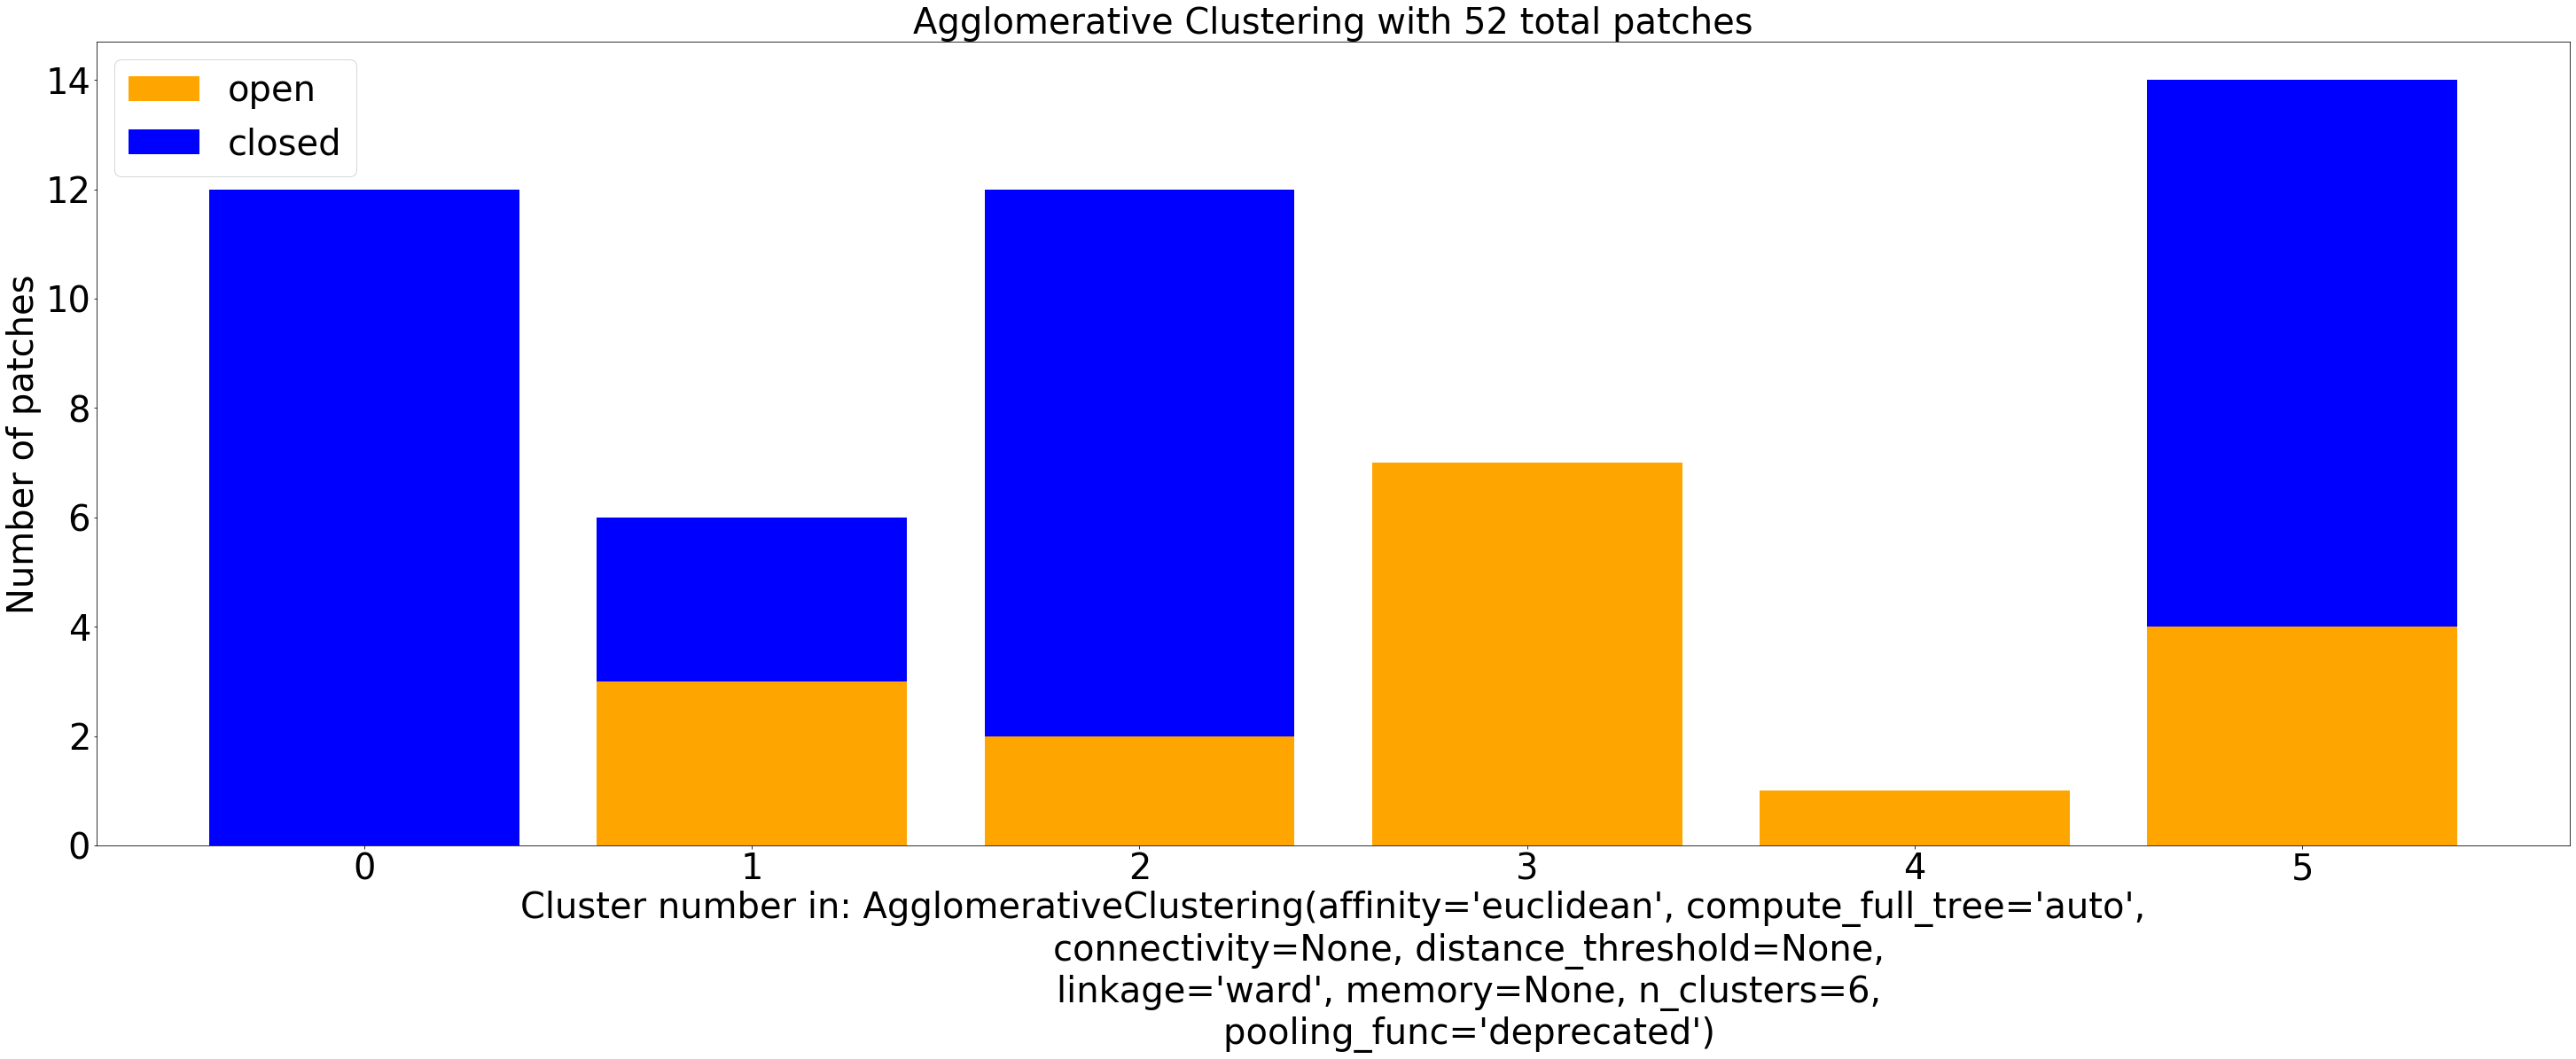

In [607]:
#create stacked bar graph 
from matplotlib import rc

plt.figure(figsize=(50,20))

# Heights of bars
bars = [len(open_clusters), len(closed_clusters)]

# The position of the bars on the x-axis
r = range(num_clusters)

# Label for each bar and bar width
x_labels = [str(i) for i in r]
barWidth = .8

# Create open-classified bars
plt.bar(r, open_clusters, color='orange', width=barWidth)

# Stack bars
plt.bar(r, closed_clusters, bottom=open_clusters, color='blue', width=barWidth)

# label/title graph
plt.xticks(r, x_labels, fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel("Number of patches", fontsize=40)
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
plt.legend(loc="upper right")
plt.legend(('open','closed'), fontsize=40)
plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
plt.gcf().subplots_adjust(bottom=0.25)
    
#save image
#plt.savefig('/home/rubywerman/cluster_plots/stacked_bar_graphs/%d_cluster_plot.png'%(num_clusters))

# Show graphic
plt.show()

In [611]:
# Utility function to visualize the outputs of t-SNE 
#takes in x, a 2d numpy array containing the output of the t-SNE algorithm and label, the 1d numpy array containing the labels of the dataset
#creates scatterplot with as many unique colors as the number of clusters
#source: https://www.datacamp.com/community/tutorials/introduction-t-sne
def cloud_scatter(x, label):
    #make a color palette with seaborn
    num_colors = len(np.unique(label))
    palette = np.array(sns.color_palette("hls", num_colors))
    
    #make scatter plot
    f = plt.figure(figsize=(50,20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=10, s=40, c=palette[label.astype(np.int)])
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []
    for i in range(num_colors):
        # Position of each label at median of data points.
        xtext, ytext = np.median(x[label == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=40)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        plt.title("Visualization of %d patches in %s clusters produced by t-SNE"%(len(label), num_clusters), fontsize=40)
        plt.gcf().subplots_adjust(bottom=0.25)
        #plt.savefig('/home/rubywerman/cluster_plots/tsne_plots/%d_tsne.png'%(num_clusters))
        # Show graphic
    return f, ax, sc, txts

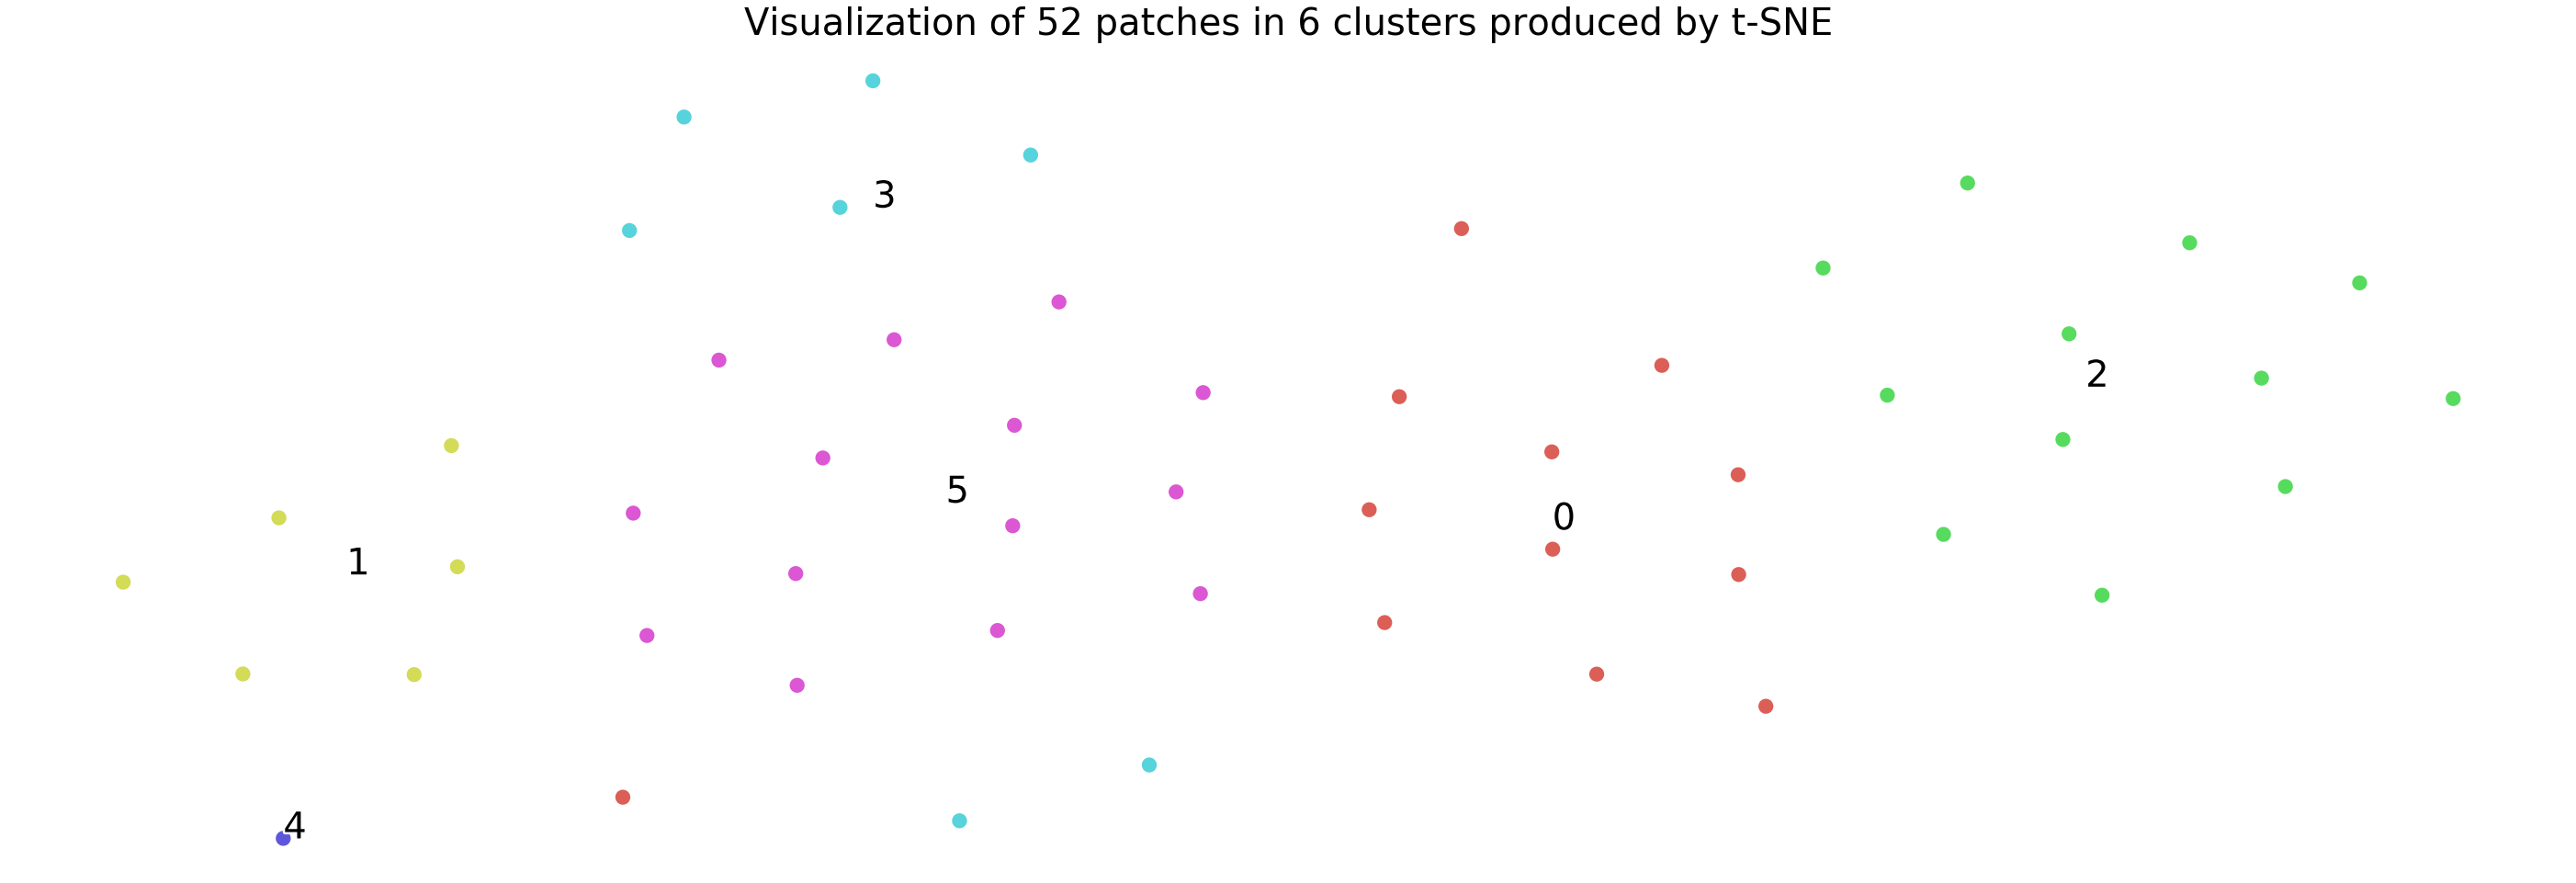

In [612]:
#visualize t-SNE 
from sklearn.manifold import TSNE
cloud_tsne = TSNE().fit_transform(cleaned_features)
plot = cloud_scatter(cloud_tsne, label)

In [613]:
# cluster_labels = range(num_clusters)
df1 = pd.DataFrame(list(zip(open_clusters, closed_clusters)), 
               columns =['open', 'closed']) 
df1["% open"] = (df1["open"] / (df1["open"] + df1["closed"]))*100
df1["% closed"] = (df1["closed"] / (df1["open"] + df1["closed"]))*100
df1

,open,closed,% open,% closed
0,0,12,0.000000,100.000000
1,3,3,50.000000,50.000000
2,2,10,16.666667,83.333333
3,7,0,100.000000,0.000000
4,1,0,100.000000,0.000000
5,4,10,28.571429,71.428571


### Inspect certain clusters

In this section, look at the actual patch images that make up each cluster. Here is an opportunity to clean any bad patches out of the data and update your patch files accordingly.

In [614]:
import math

In [615]:
#returns list of open patches from a given cluster
def get_open_patches(cluster_num):
    open_in_cluster = [patch for patch in list_clusters[cluster_num].patches if patch.isOpen]
    o_list_pics = []
    for i in range(len(open_in_cluster)):
        p = open_in_cluster[i]
        o_list_pics.append(p.thirtyFive[p.coords[0]*128:p.coords[1]*128,p.coords[2]*128:p.coords[3]*128])
    return o_list_pics

#returns list of closed patches from a given cluster
def get_closed_patches(cluster_num):
    closed_in_cluster = [patch for patch in list_clusters[cluster_num].patches if not patch.isOpen]
    c_list_pics = []
    for i in range(len(closed_in_cluster)):
        p = closed_in_cluster[i]
        c_list_pics.append(p.thirtyFive[p.coords[0]*128:p.coords[1]*128,p.coords[2]*128:p.coords[3]*128])
    return c_list_pics

In [616]:
#creates a grid of open or closed patches from a given cluster 
def show_patch_grid(cluster_num, isOpen):
    if isOpen:
        arr = get_open_patches(cluster_num)
        strs = "open"
    else:
        arr = get_closed_patches(cluster_num)
        strs = "closed"
        
    if len(arr) > 0:
        row = col = math.ceil(math.sqrt(len(arr))) 
        arr_iter = iter(arr)
        nums = iter(range(len(arr)))
        
        f, axarr = plt.subplots(row,col, figsize=(40,40))
        plt.subplots_adjust(hspace=.5)
        for r in range(row):
            for c in range(col):
                try:
                    axarr[r,c].imshow(next(arr_iter))
                    axarr[r,c].axis('off')
                    axarr[r,c].set_title('%d'%(next(nums)), fontsize=60)
                except:
                    while r < row:
                        while c < col:
                            plt.delaxes()
                            c += 1
                        r += 1
                    break
        f.suptitle('Cluster %d %s'%(cluster_num, strs), fontsize=60)
        plt.show()

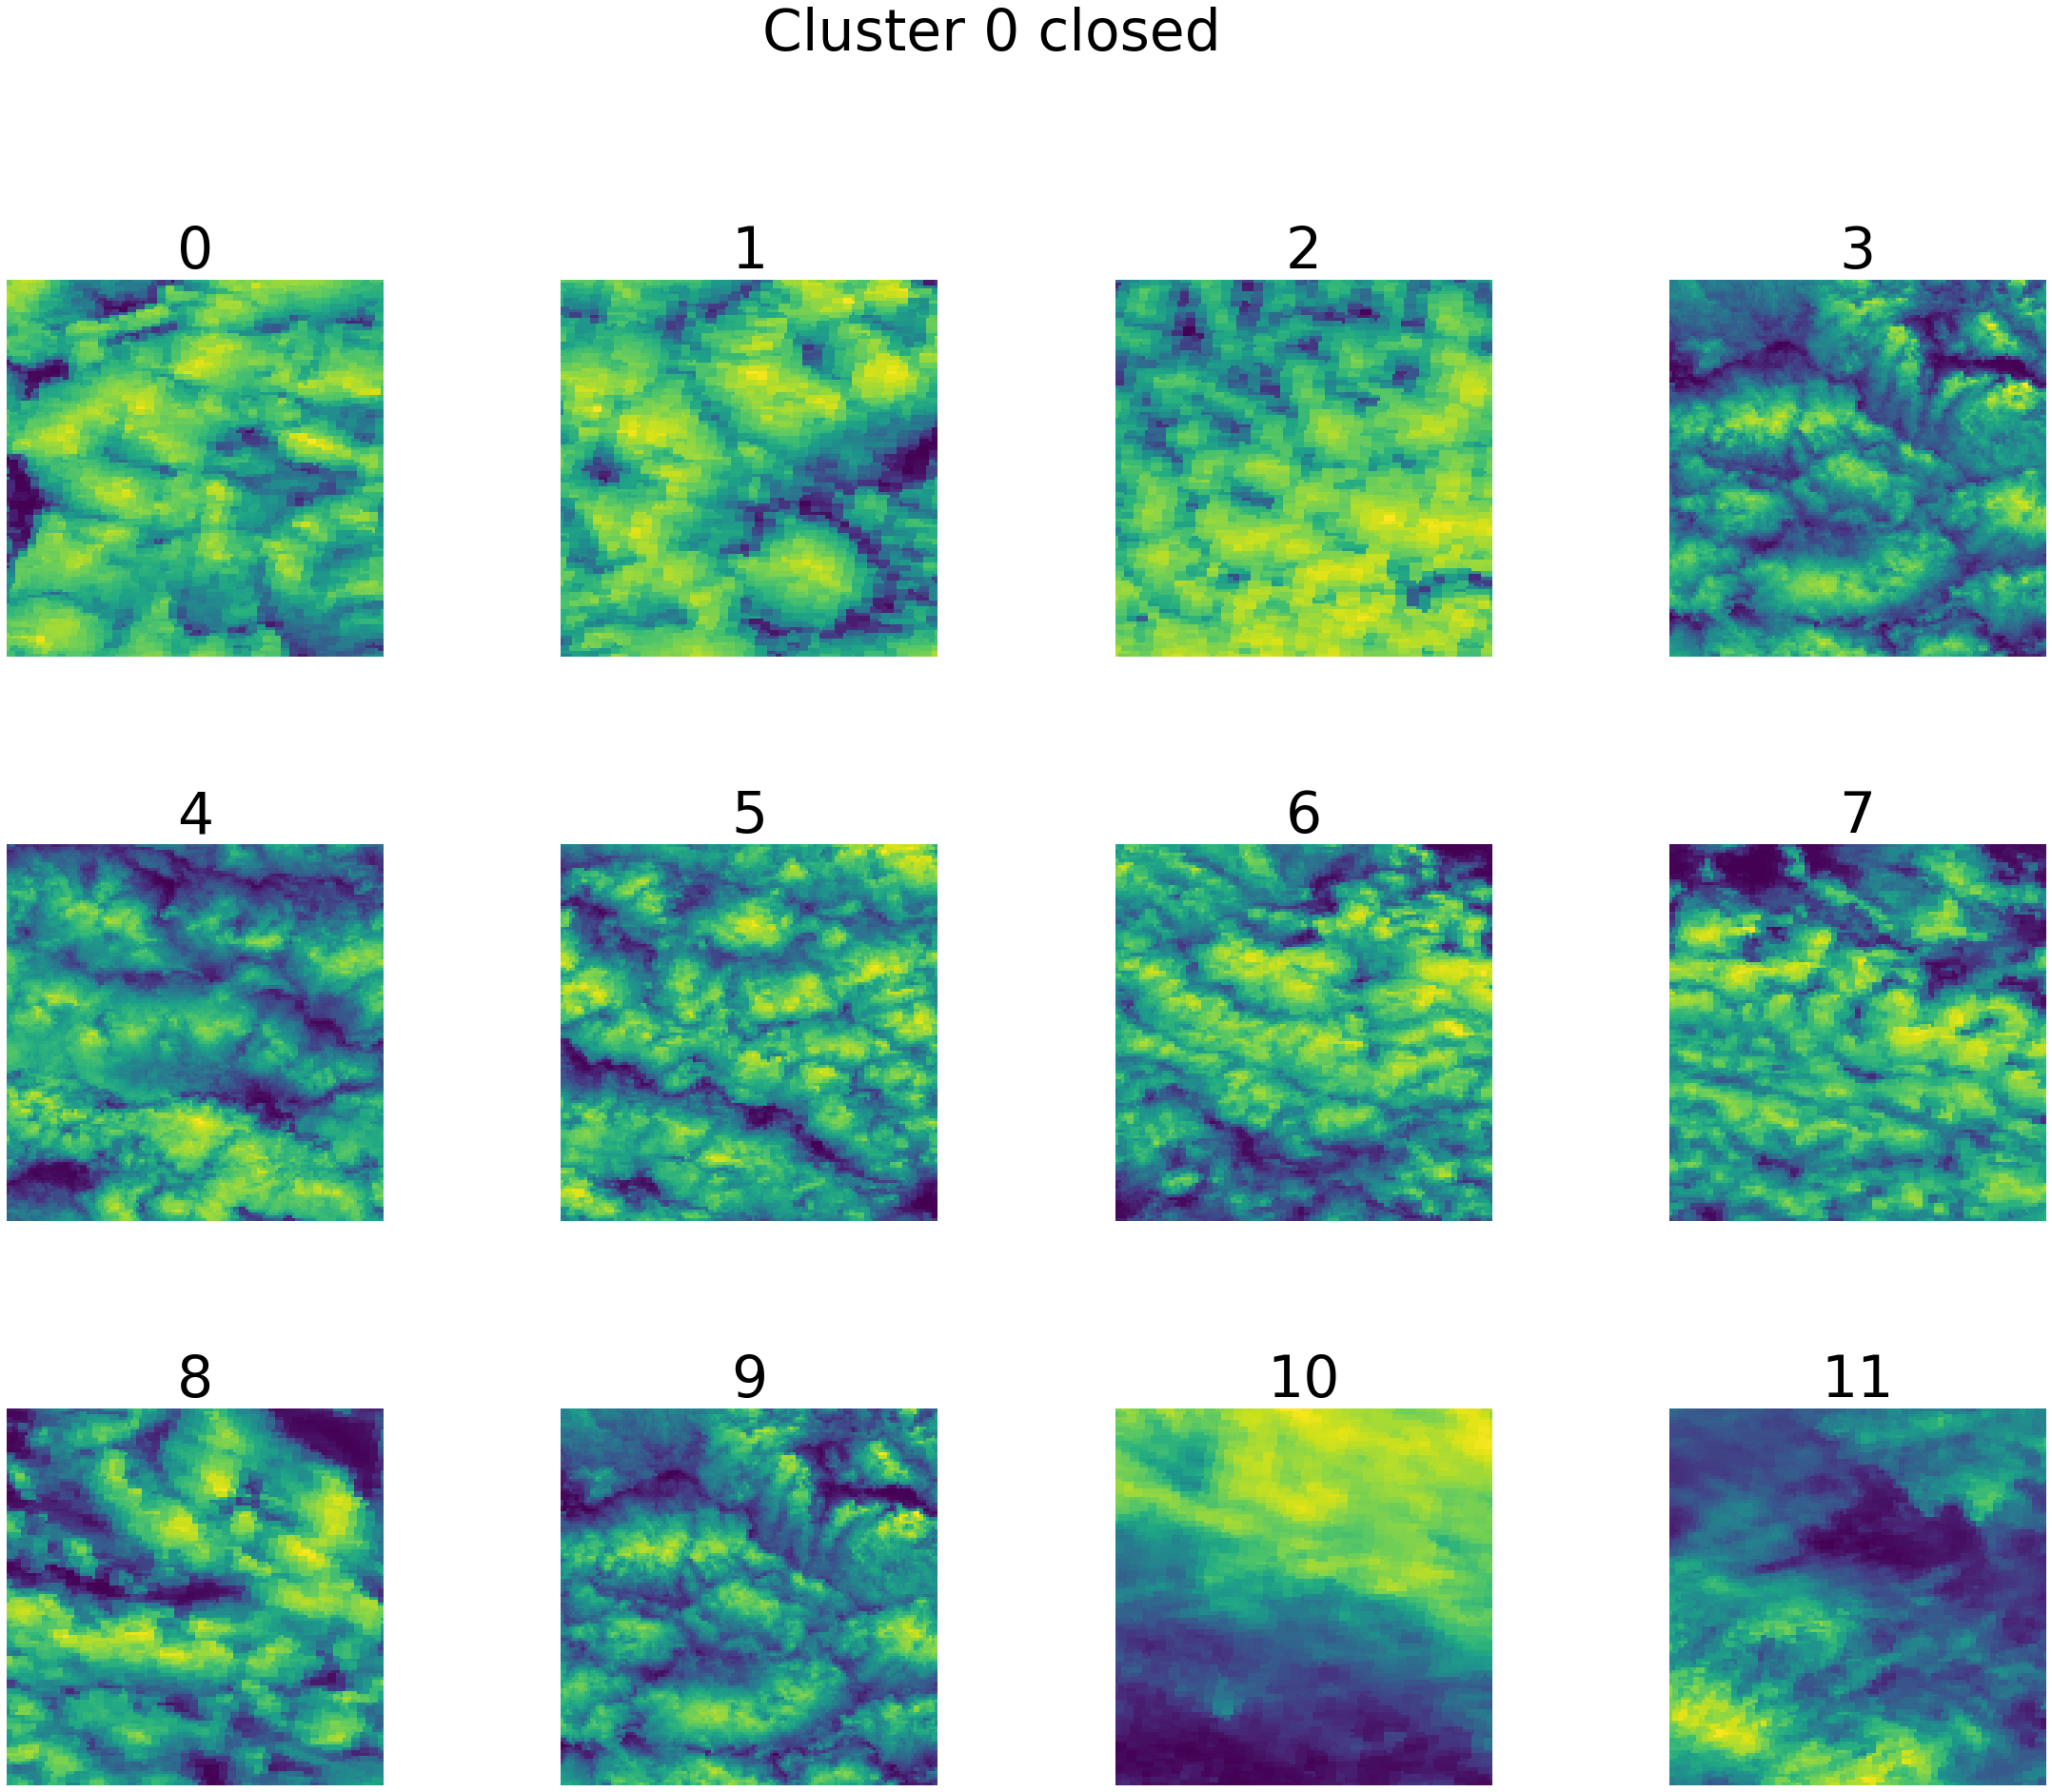

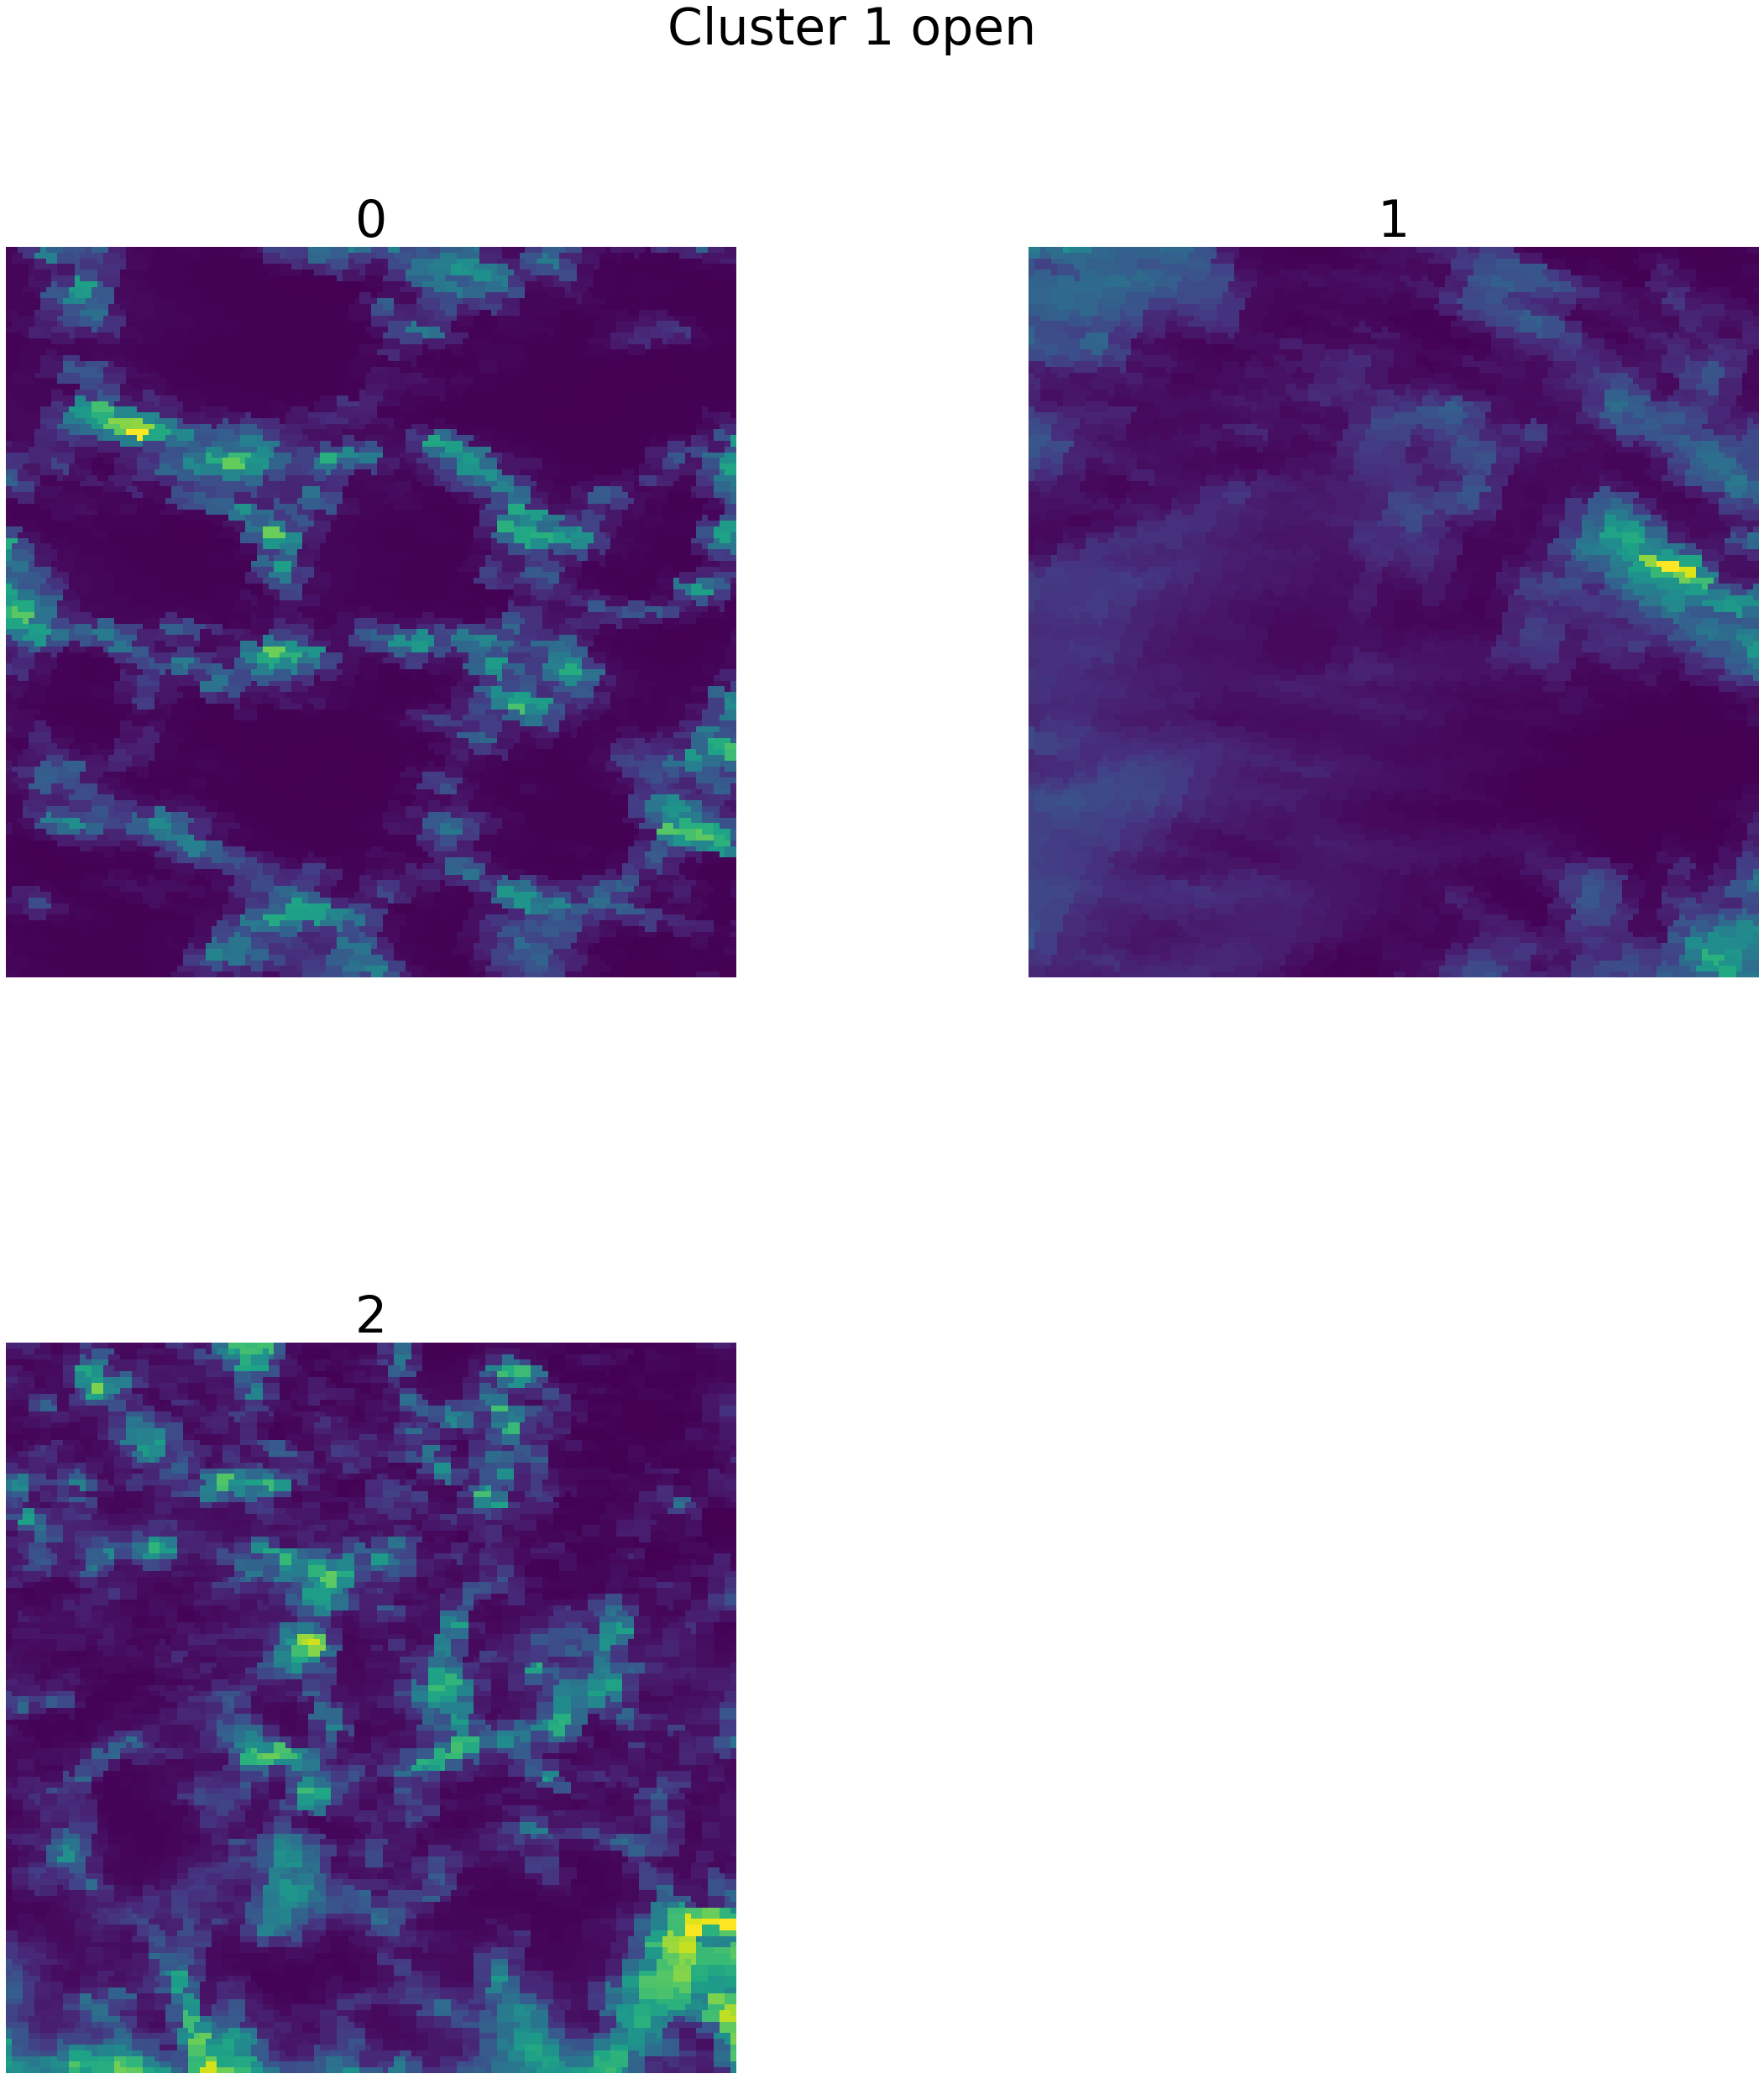

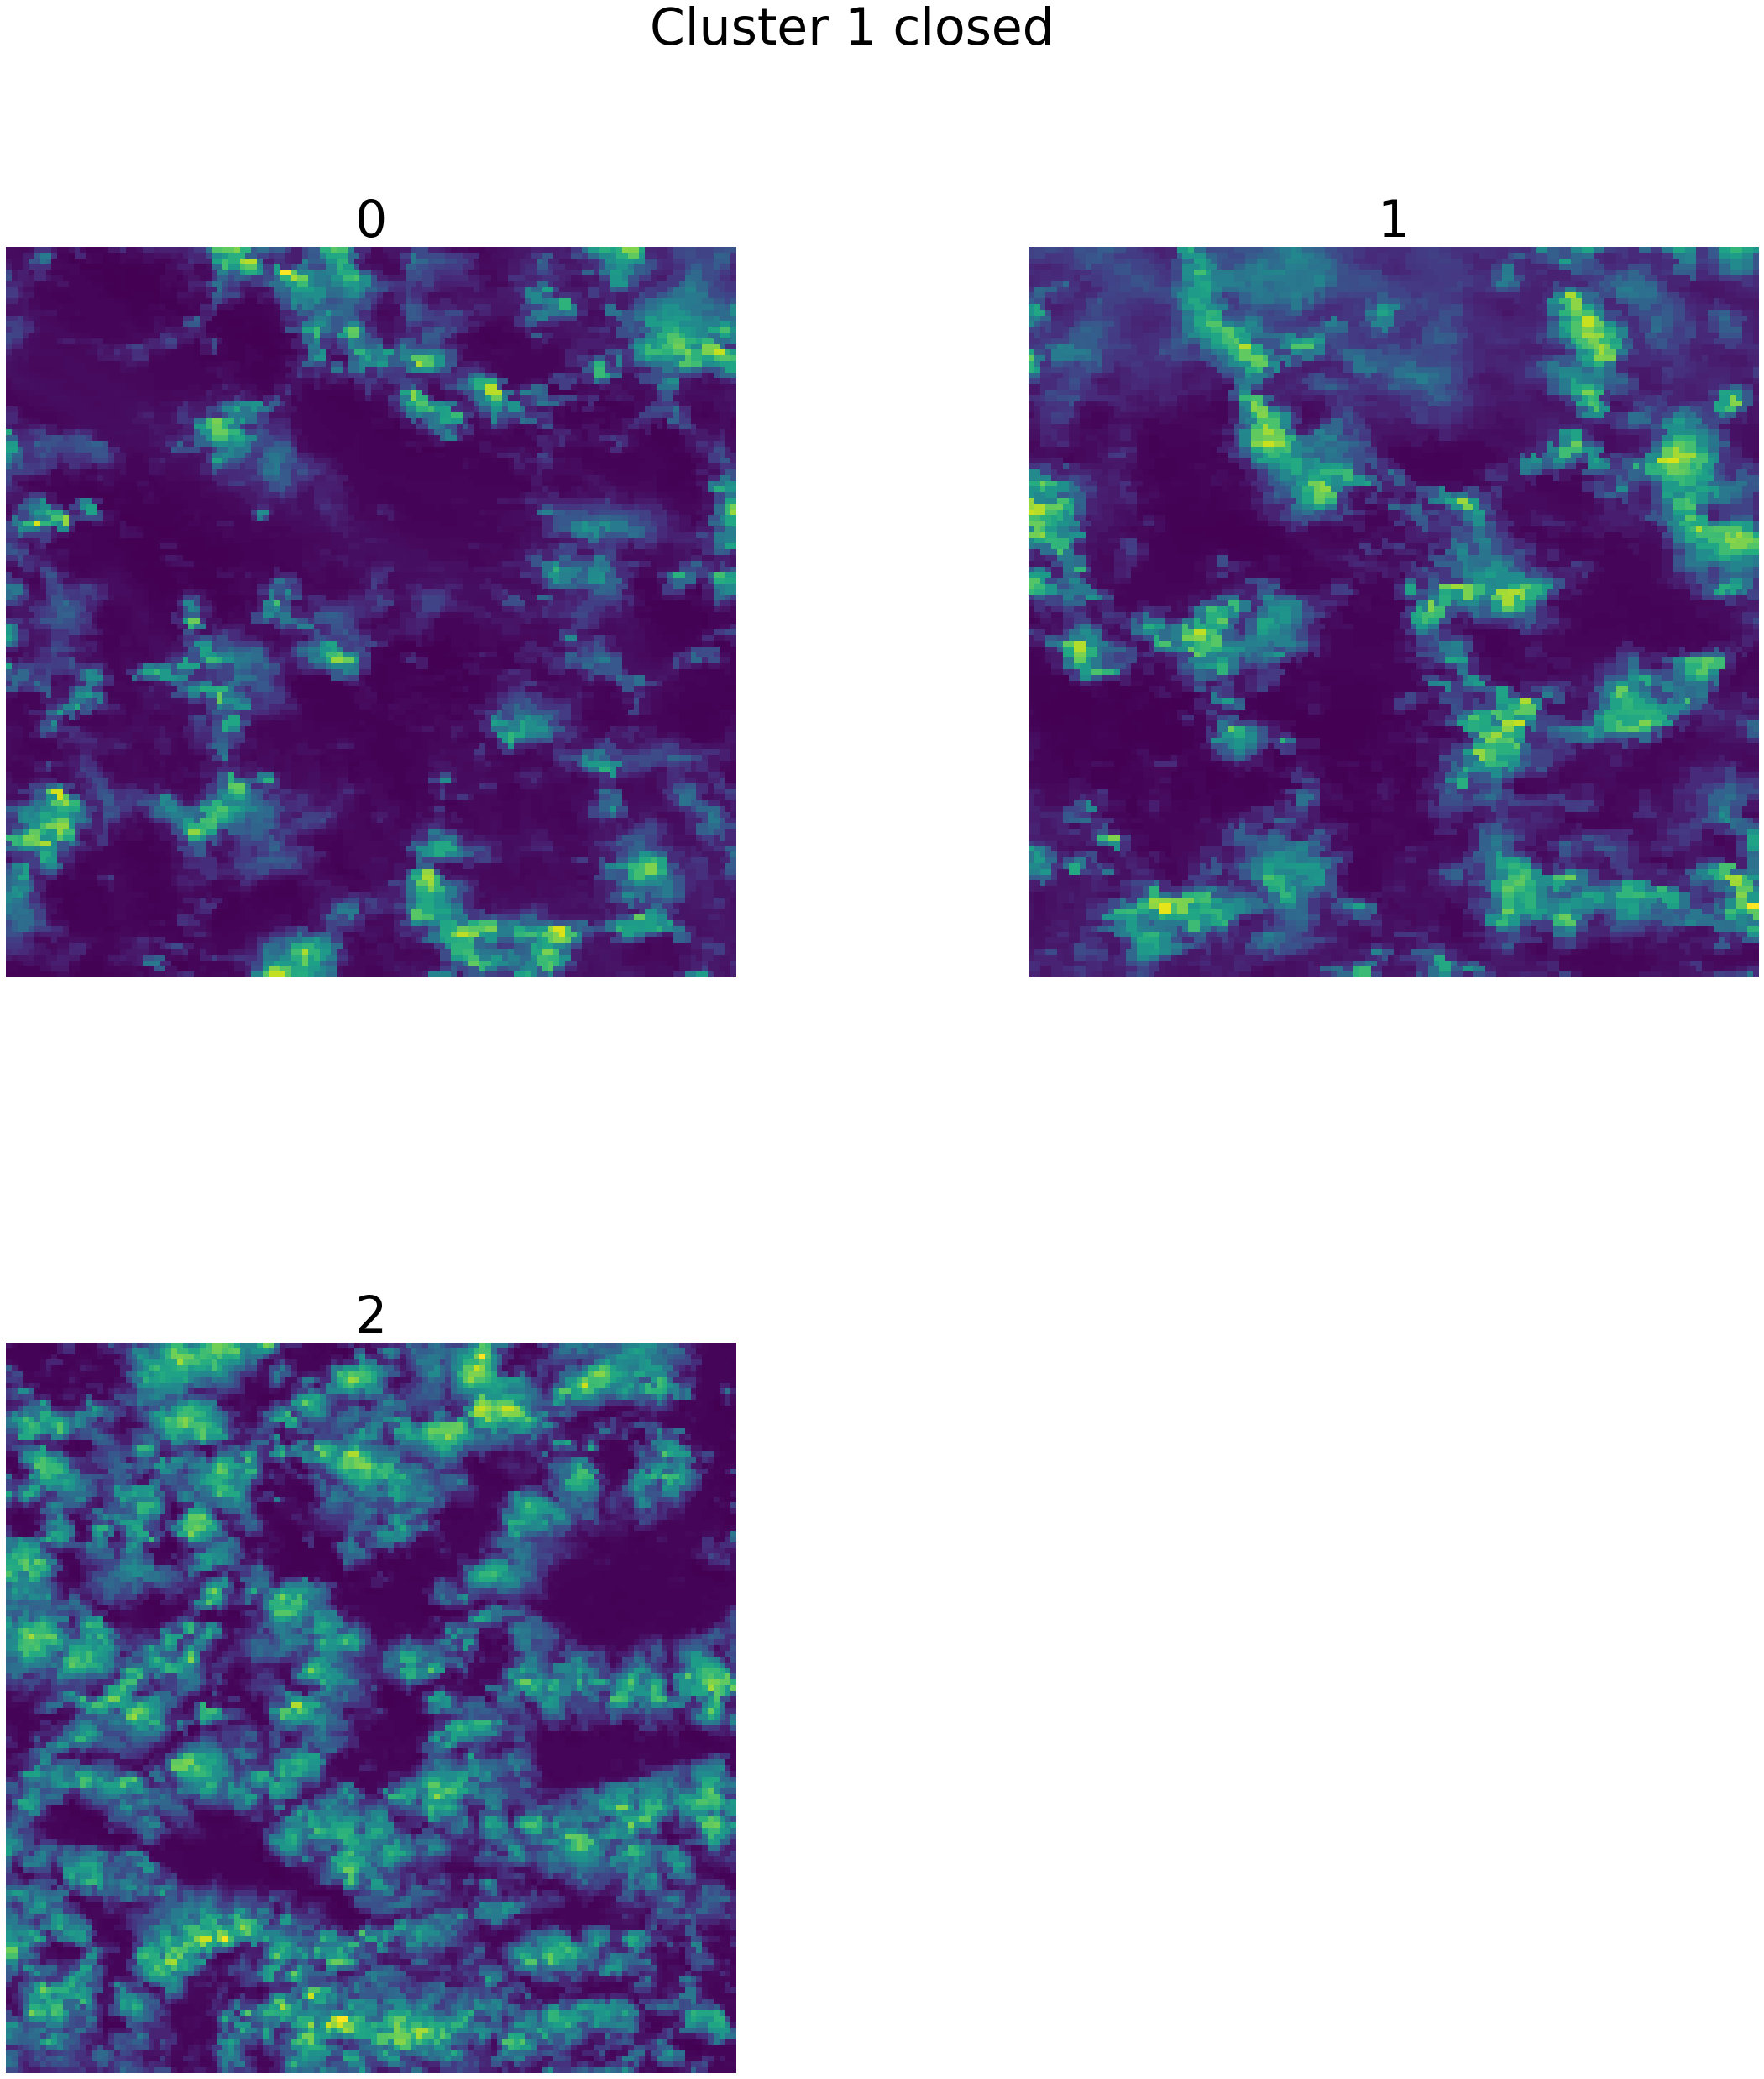

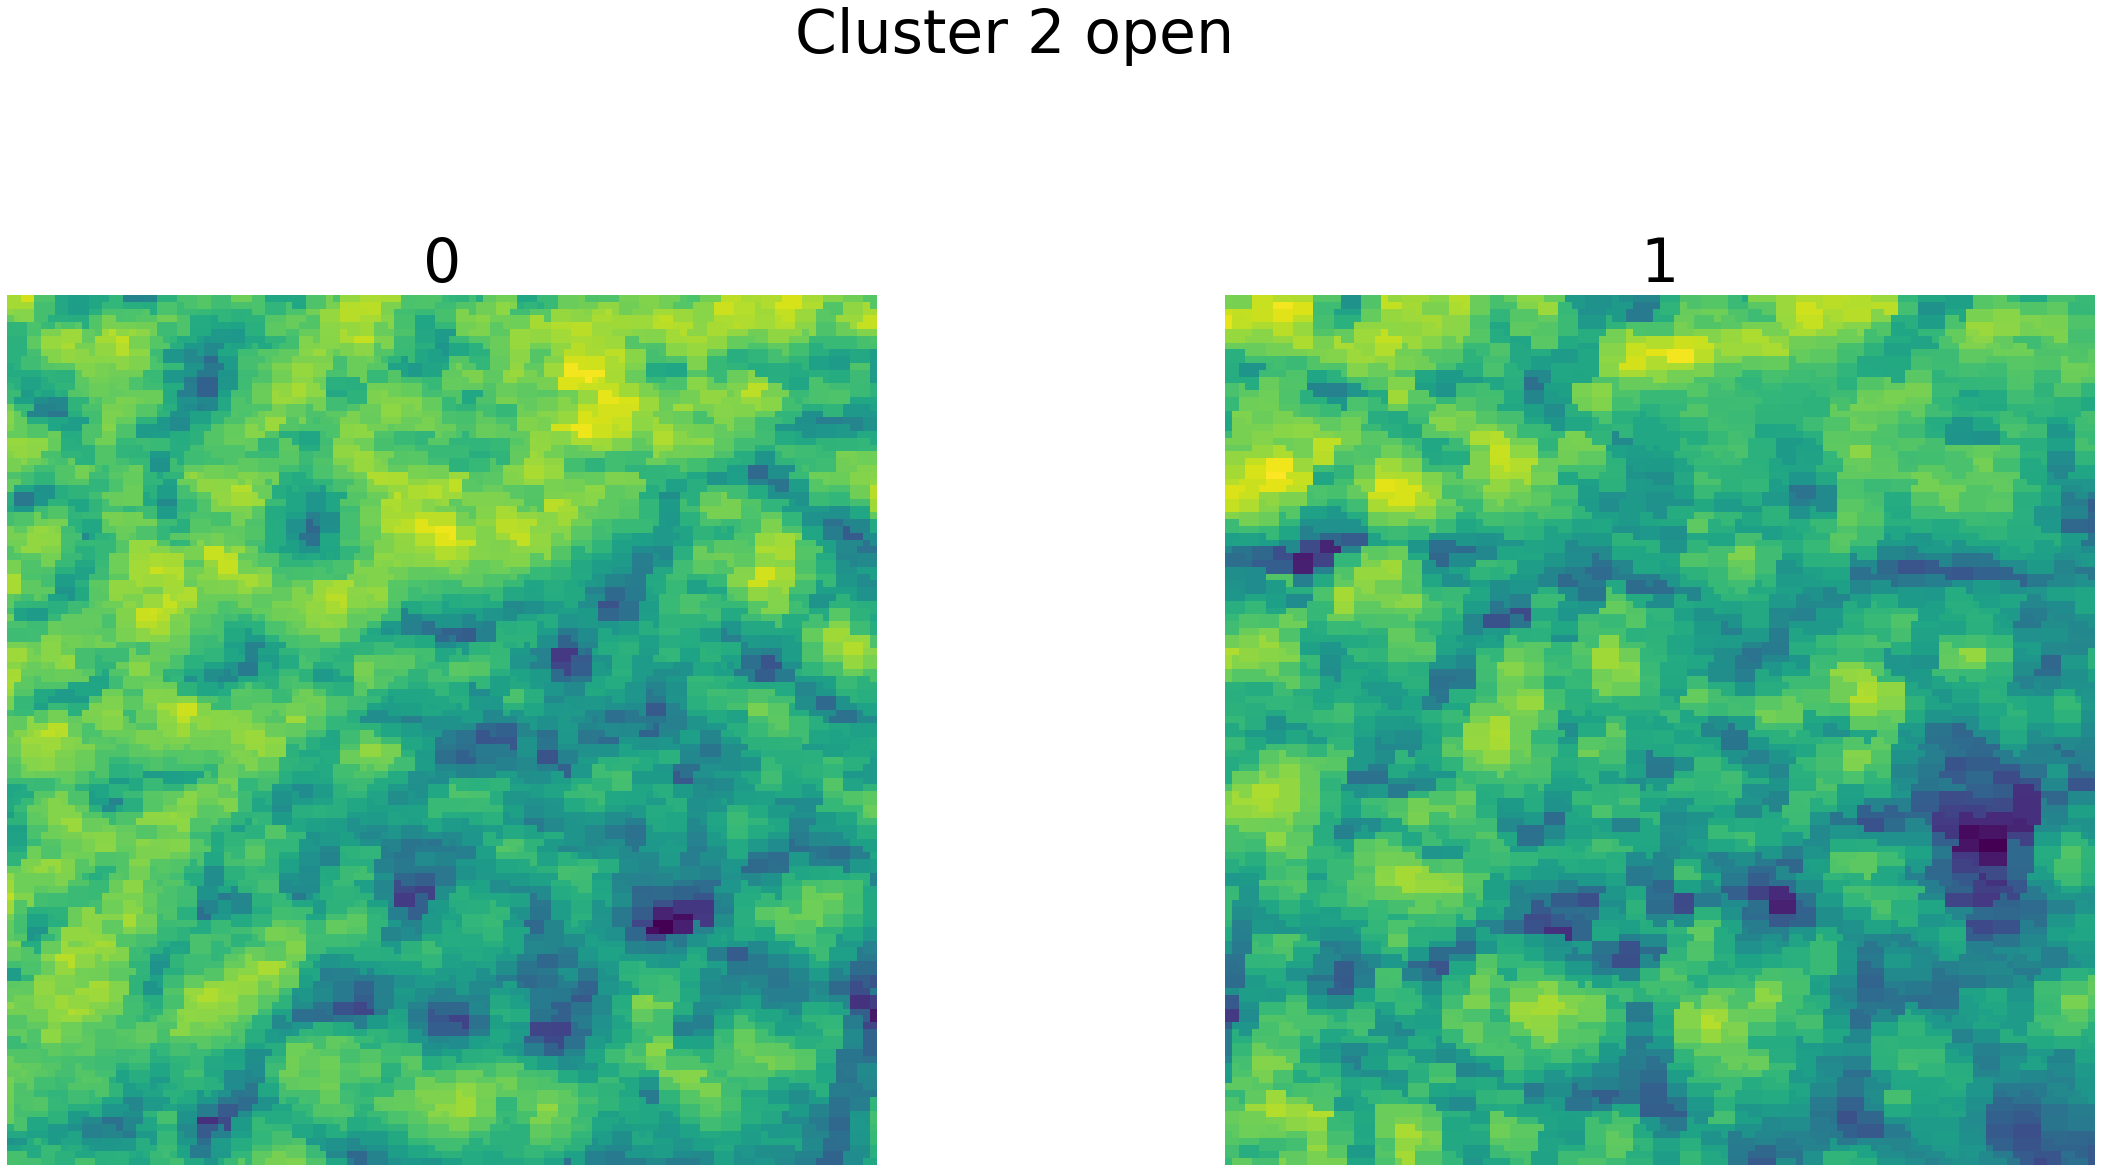

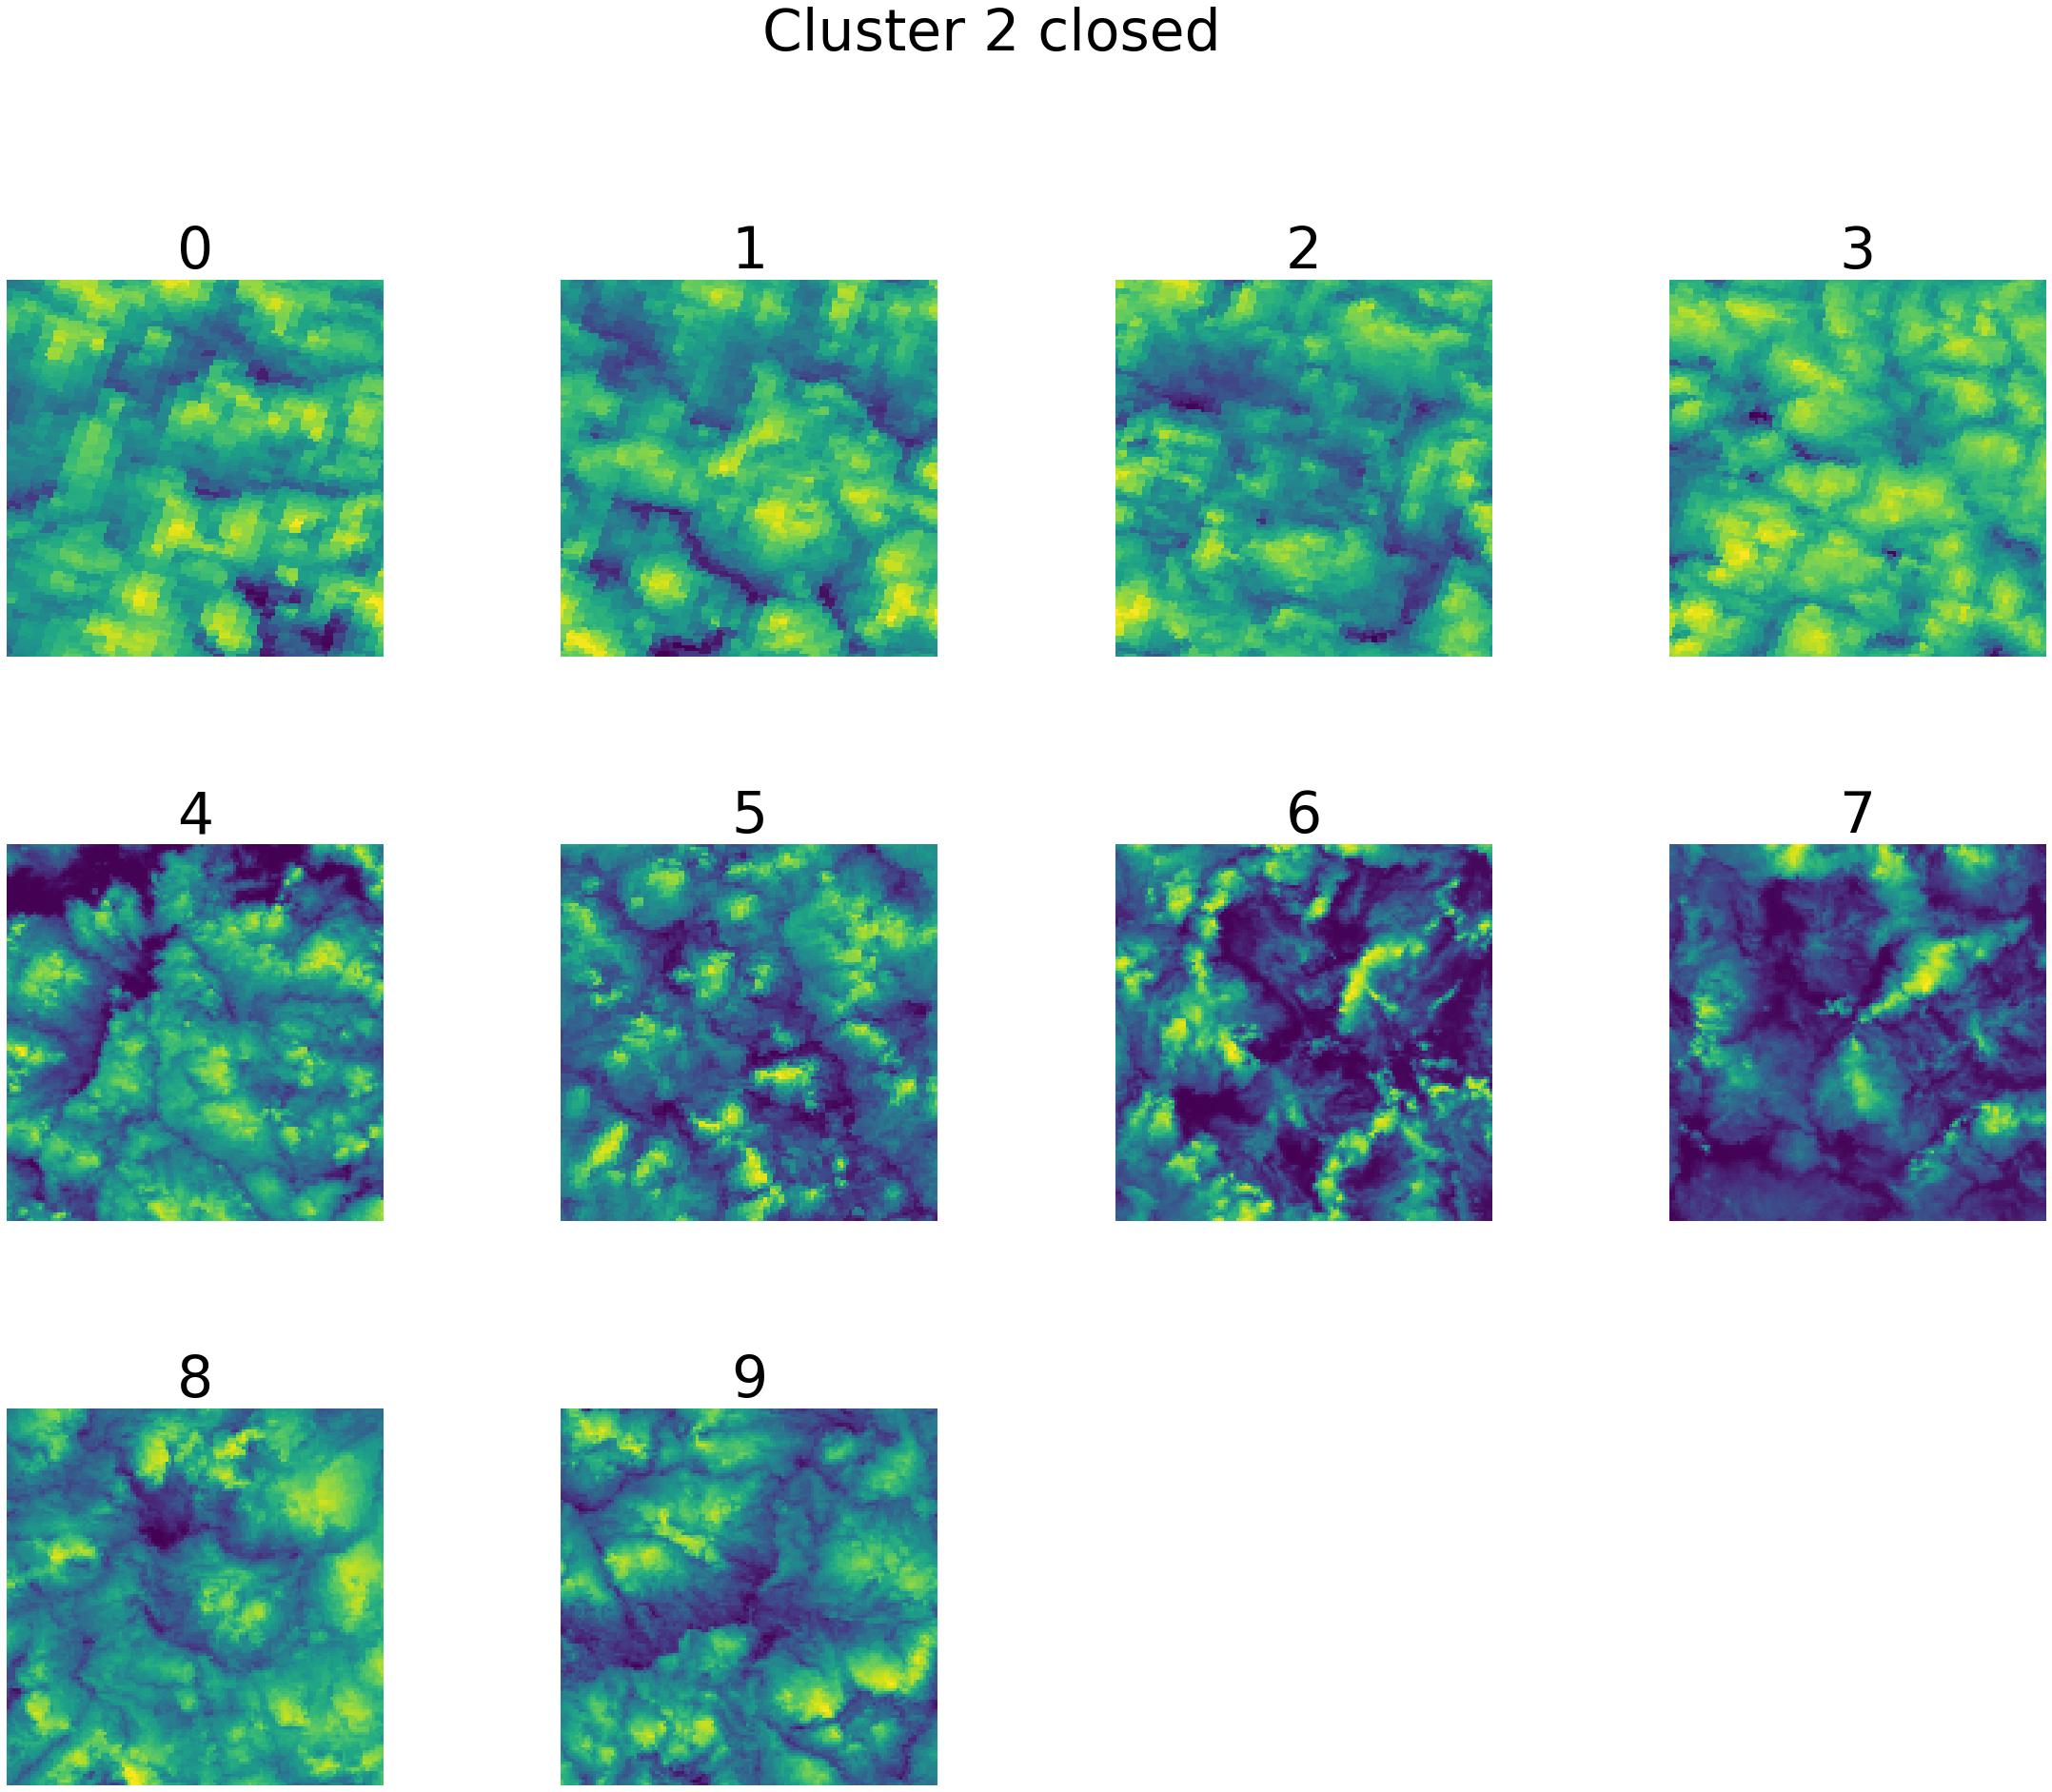

In [ ]:
#display the patch groupings for every cluster
for i in range(num_clusters):
    show_patch_grid(i, isOpen=True)
    show_patch_grid(i, isOpen=False)

## Remove bad patches

In [ ]:
#removes desired patches from the cluster object's patch list
def remove_closed(cluster_num, indices):
    cluster = list_clusters[cluster_num]
    closed = [p for p in cluster.patches if not p.isOpen]
    to_save = [p for p in cluster.patches if p.isOpen]
    updated = to_save
    for i in range(len(closed)):
        if i not in indices:
            updated.append(cluster.patches[i])
    cluster.patches = updated
#removes desired patches from the cluster object's patch list
def remove_open(cluster_num, indices):
    cluster = list_clusters[cluster_num]
    to_save = [p for p in cluster.patches if not p.isOpen]
    openx = [p for p in cluster.patches if p.isOpen]
    updated = to_save
    for i in range(len(openx)):
        if i not in indices:
            updated.append(cluster.patches[i])
    cluster.patches = updated

Create an updated patch list named `cleaned_patches`.

In [708]:
cleaned_patches = []
for c in list_clusters:
    cleaned_patches.extend(c.patches)

In [709]:
#write new date data
updated_open_dates = set()
updated_closed_dates = set()
for p in cleaned_patches:
    if p.isOpen:
        updated_open_dates.add(p.date)
    else:
        updated_closed_dates.add(p.date)       

Call the `save()` function below to write new updated date files and a file of patches stored in a list of patch instances.

In [710]:
#save updated patch date list and class patch list
def save():
    closed_sp = closed_file_name[:-6] 
    open_sp = open_file_name[:-6] 
    if len(list(updated_closed_dates)) < len(closed_dates):
        np.save(closed_sp + "_cleaned.npy",list(updated_closed_dates))
    if len(list(updated_open_dates)) < len(open_dates):
        np.save(open_sp + "_cleaned.npy", list(updated_open_dates))
    #save cleaned patch list
    np.save('/home/rubywerman/clouds/src_analysis/class_patch_data/071619.npy', cleaned_patches)

Call the save06() function below to write only the coordinates and dates to a file

In [59]:
def save06(class_patch_list):
    #creates a list of tuples (date, [coordinates]) for each patch
    sp = "/home/rubywerman/clouds/src_analysis/labeled_data/coords_dates/coords_dates.npy"
    np.save(sp, [(patch.date, patch.coords) for patch in class_patch_list])

# Visualize clustering on cleaned patches

Below you can re-cluster the patches and see how the clustering differs through visualization.

In [1]:
encs_list1 = []
for patch in cleaned_patches:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list1 += [encs.mean(axis=(1,2))]
        
features1 = np.concatenate(encs_list1, axis=0)

NameError: name 'cleaned_patches' is not defined

In [712]:
clustering1 = AgglomerativeClustering(num_clusters)
cleaned_features1 = np.nan_to_num(features1)
label1 = clustering1.fit_predict(cleaned_features1)

In [713]:
##NOTE: reassigns patch labels!
for i in range(len(cleaned_patches)):
    cleaned_patches[i].label = label1[i]

list_clusters1 = [Cluster(label=i) for i in range(num_clusters)]

for p in cleaned_patches:
    matching_cluster1 = list_clusters1[p.label]
    if p.isOpen:
        matching_cluster1.num_open += 1
    if not matching_cluster1.patches:
        matching_cluster1.patches = [p]
    else:
        matching_cluster1.patches.append(p)

for c in list_clusters1:
    c.means = get_band_means(c.patches)
    c.std = get_band_std(c.patches)
    
open_clusters1 = [i.num_open for i in list_clusters1]
closed_clusters1 = [len(i.patches) - i.num_open for i in list_clusters1]

W0716 13:47:56.290957 140296762263360 legend.py:1282] No handles with labels found to put in legend.


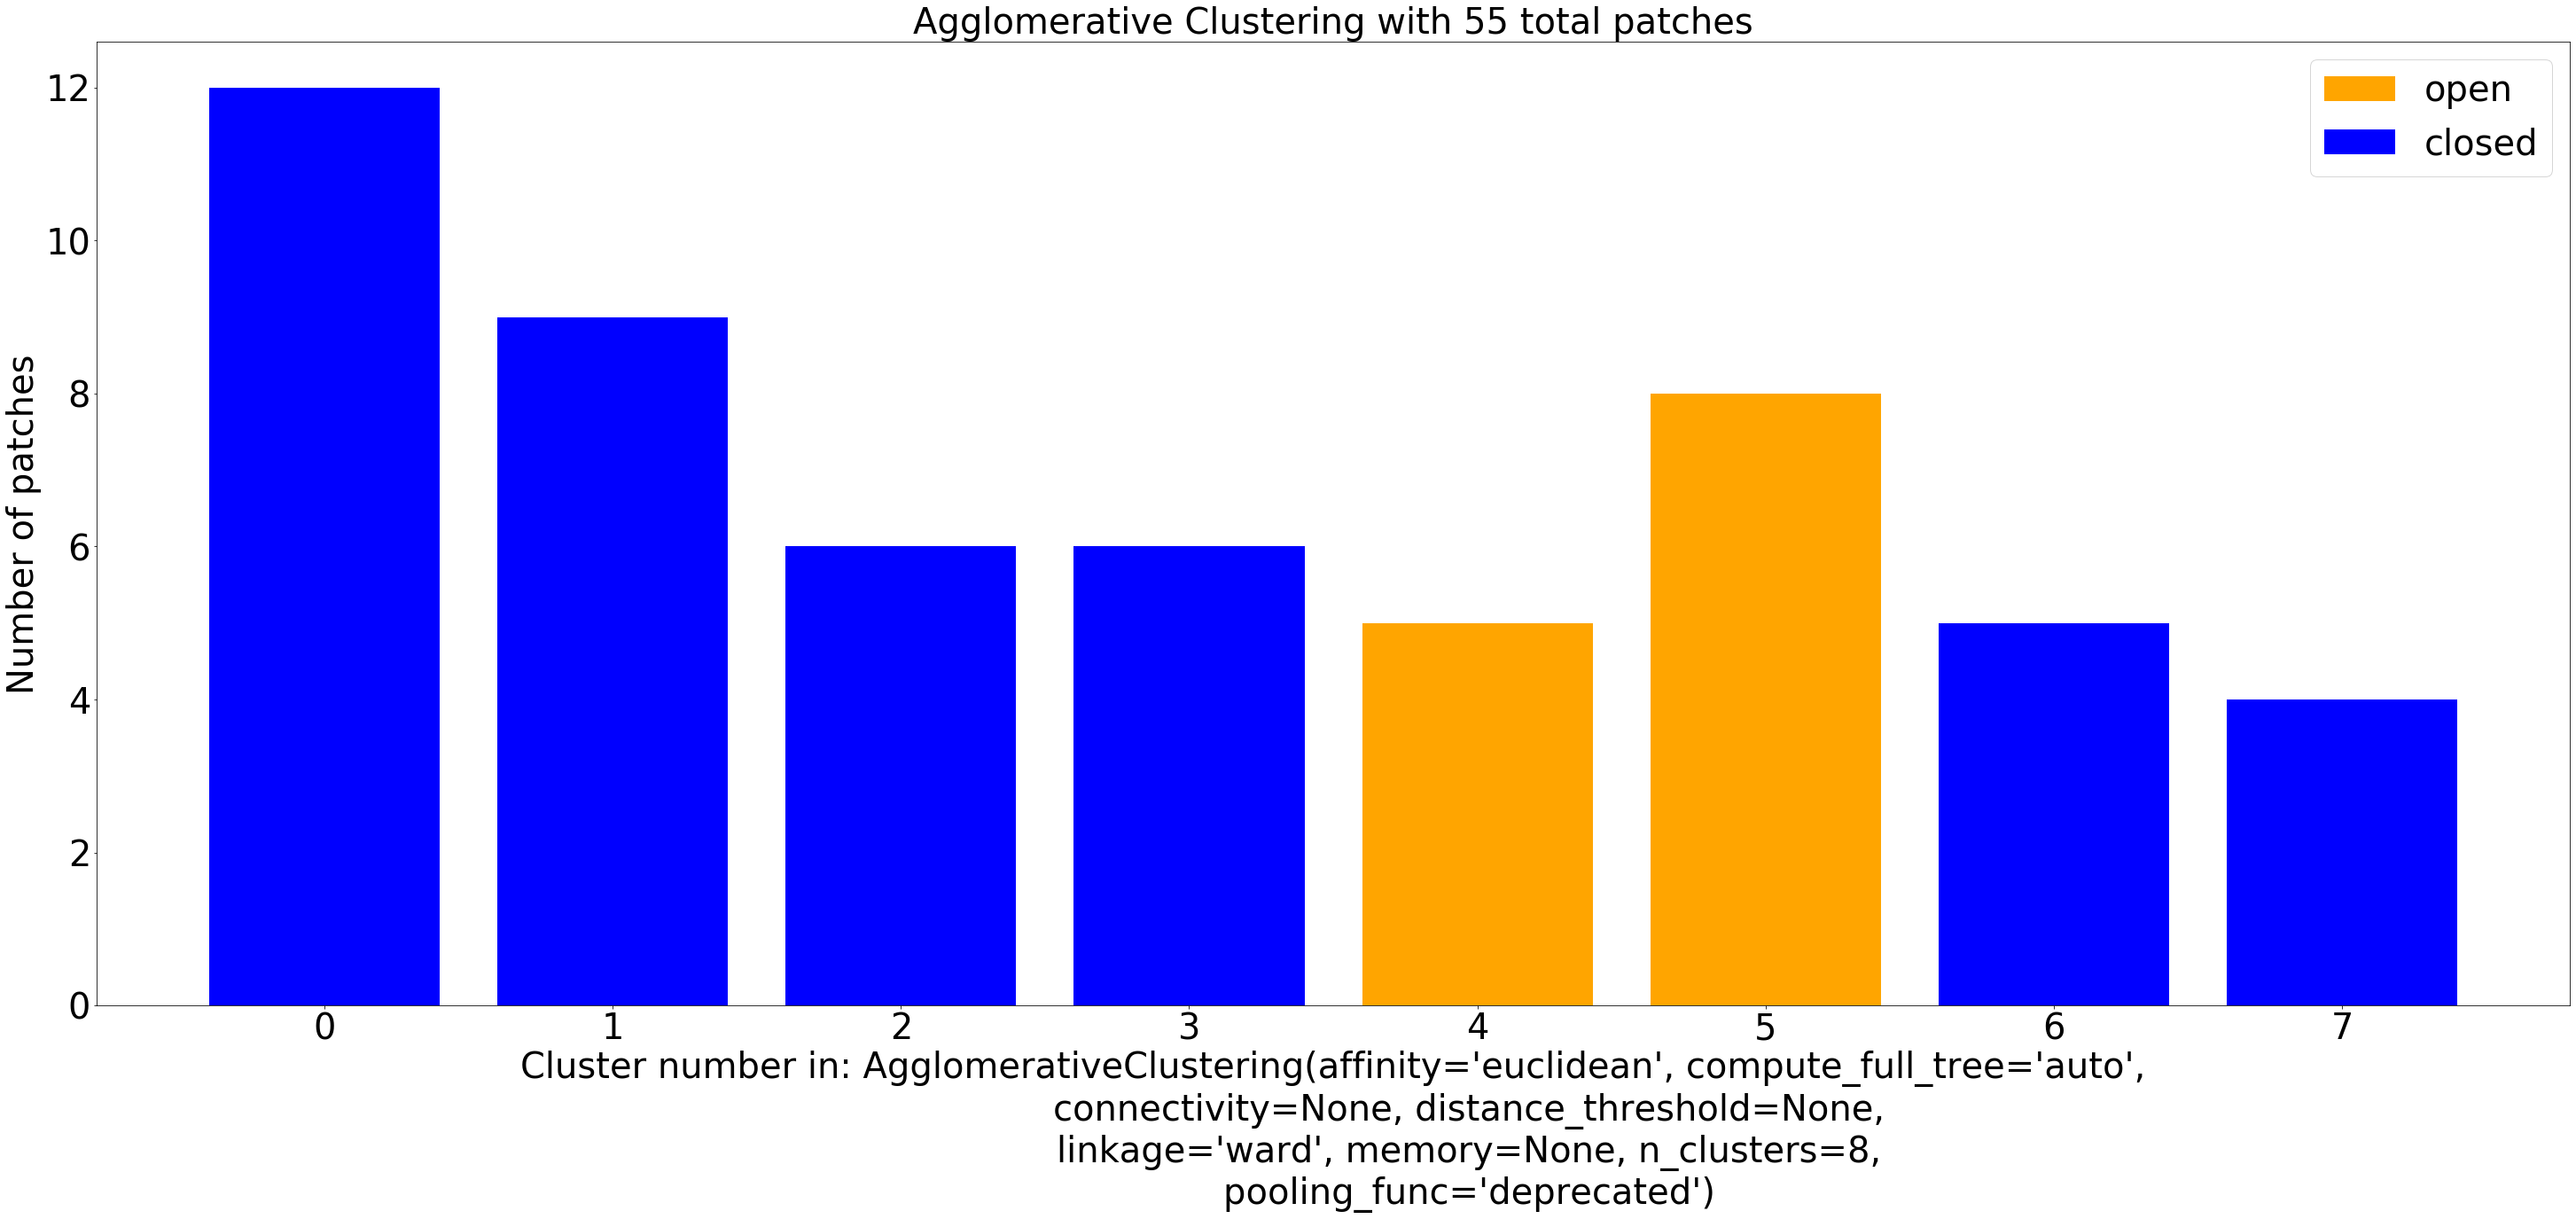

In [714]:
#create stacked bar graph 
plt.figure(figsize=(50,20))

# Heights of bars
bars = [len(open_clusters1), len(closed_clusters1)]

# The position of the bars on the x-axis
r = range(num_clusters)

# Label for each bar and bar width
x_labels = [str(i) for i in r]
barWidth = .8

# Create open-classified bars
plt.bar(r, open_clusters1, color='orange', width=barWidth)

# Stack bars
plt.bar(r, closed_clusters1, bottom=open_clusters1, color='blue', width=barWidth)

# label/title graph
plt.xticks(r, x_labels, fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel("Number of patches", fontsize=40)
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
plt.legend(loc="upper right")
plt.legend(('open','closed'), fontsize=40)
plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
plt.show()

In [715]:
df1["cleaned open"] = open_clusters1
df1["cleaned closed"] = closed_clusters1
df1["cleaned % open"] = (df1["cleaned open"] / (df1["cleaned open"] + df1["cleaned closed"]))*100
df1["cleaned % closed"] = (df1["cleaned closed"] / (df1["cleaned open"] + df1["cleaned closed"]))*100
df1

,open,closed,% open,% closed,cleaned open,cleaned closed,cleaned % open,cleaned % closed
0,0,12,0.0,100.0,0,12,0.0,100.0
1,0,9,0.0,100.0,0,9,0.0,100.0
2,0,6,0.0,100.0,0,6,0.0,100.0
3,0,6,0.0,100.0,0,6,0.0,100.0
4,5,0,100.0,0.0,5,0,100.0,0.0
5,8,0,100.0,0.0,8,0,100.0,0.0
6,0,5,0.0,100.0,0,5,0.0,100.0
7,0,4,0.0,100.0,0,4,0.0,100.0


# Stuff to do, stuff to organize

Below is some unfinished code that will eventually create a distribution of mean intensity per patch

In [716]:
# visualize std for each band for each cluster
n_groups = 6

def get_cluster_means(list_clusters, i):
    return list_clusters[i].means

def get_cluster_std(list_clusters, i):
    return list_clusters[i].std

<Figure size 3600x3600 with 0 Axes>

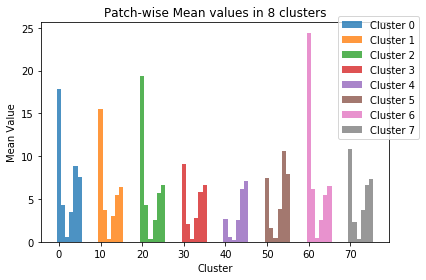

In [745]:
# create plot
f = plt.figure(figsize=(50,50))

fig, ax = plt.subplots()
index = bar_width*np.arange(n_groups)
bar_width = 1
opacity = 0.8


for i in range(num_clusters):
    plt.bar(index + bar_width*i*10, get_cluster_means(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

plt.xlabel('Cluster')
#plt.xticks(range(num_clusters))

plt.ylabel('Mean Value')
plt.title('Patch-wise Mean values in %d clusters'%num_clusters)
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()


<Figure size 1440x216 with 0 Axes>

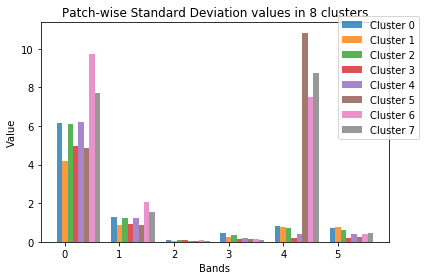

In [507]:
# visualize std for each band for each cluster
n_groups = 6

# create plot
f = plt.figure(figsize=(20,3))

fig, ax = plt.subplots()
index = 10*np.arange(n_groups)
bar_width = 1
opacity = 0.8

#make bars for each cluster
for i in range(num_clusters):
    plt.bar(index + bar_width*i, get_cluster_std(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

#set axes
plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Patch-wise Standard Deviation values in %d clusters'%num_clusters)
plt.xticks(index + bar_width, range(6))
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()